In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gc
import warnings
warnings.filterwarnings('ignore')
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error
import joblib


In [3]:
data=pd.read_pickle('data.pkl')
valid=data[(data['d']>=1914)&(data['d']<1942)][['id','d','sold']]
test=data[data['d']>=1942][['id','d','sold']]

In [8]:
def XGB_model(X_train,y_train,X_valid,y_valid,N_e):
    model = xgb.XGBRegressor(
        learning_rate=0.01,
        n_estimators=N_e,
        min_child_weight=0,
        max_depth=8,
        random_state=18)
    model.fit(X_train,y_train)
    y_pred = model.predict(X_valid)
    mse = mean_squared_error(y_valid, y_pred)
    print ("RMSE:",mse**(1/2))

    return model

50
RMSE: 2.8140203816991383
100
RMSE: 2.3746051460099187
150
RMSE: 2.1846125483107004
200
RMSE: 2.1069099999584235
250
RMSE: 2.075470225356546
300
RMSE: 2.0623453255656106
350
RMSE: 2.055715093636181
400
RMSE: 2.051990435929346


In [ ]:
N_e_list=[50,100,150,200,250,300,350,400]


df= data[data['store_id']==0]
X_train,y_train=df[df['d']<1914].drop('sold',axis=1),df[df['d']<1914]['sold']
X_valid,y_valid=df[(df['d']>=1914)&(df['d']<1942)].drop('sold',axis=1),df[(df['d']>=1914)&(df['d']<1942)]['sold']

for N_e in N_e_list:
    print (N_e)
    model= XGB_model(X_train,y_train,X_valid,y_valid,N_e)
    del model
    gc.collect()

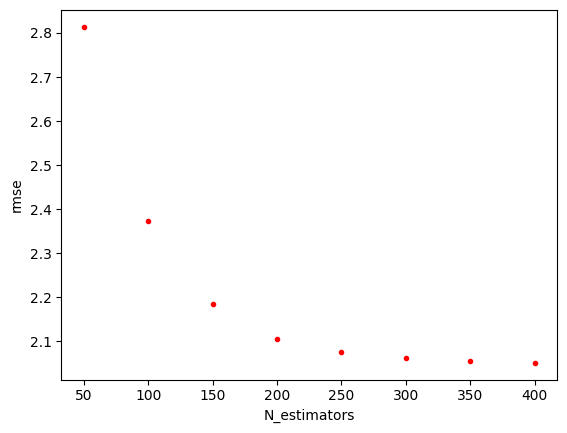

In [10]:
rmse_list= [2.814,2.374,2.184,2.106,2.075,2.062,2.055,2.051]
plt.plot(N_e_list,rmse_list,'r.')
plt.xlabel('N_estimators')
plt.ylabel('rmse')
plt.savefig('N_e_test.png')

In [11]:
cal=pd.read_csv('./data/calendar.csv')
sales_train_evaluation=pd.read_csv('data/sales_train_evaluation.csv')

In [12]:
def downcase(df):  
    cols = df.dtypes.index.tolist()
    types = df.dtypes.values.tolist()
    for i,t in enumerate(types):
        if 'int' in str(t):
            if df[cols[i]].min() > np.iinfo(np.int8).min and df[cols[i]].max() < np.iinfo(np.int8).max:
                df[cols[i]] = df[cols[i]].astype(np.int8)
            elif df[cols[i]].min() > np.iinfo(np.int16).min and df[cols[i]].max() < np.iinfo(np.int16).max:
                df[cols[i]] = df[cols[i]].astype(np.int16)
            elif df[cols[i]].min() > np.iinfo(np.int32).min and df[cols[i]].max() < np.iinfo(np.int32).max:
                df[cols[i]] = df[cols[i]].astype(np.int32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.int64)
        elif 'float' in str(t):
            if df[cols[i]].min() > np.finfo(np.float16).min and df[cols[i]].max() < np.finfo(np.float16).max:
                df[cols[i]] = df[cols[i]].astype(np.float16)
            elif df[cols[i]].min() > np.finfo(np.float32).min and df[cols[i]].max() < np.finfo(np.float32).max:
                df[cols[i]] = df[cols[i]].astype(np.float32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.float64)
        elif t == np.object:
            if cols[i] == 'date':
                df[cols[i]] = pd.to_datetime(df[cols[i]], format='%Y-%m-%d')
            else:
                df[cols[i]] = df[cols[i]].astype('category')
    return df

In [13]:
cal=downcase(cal)
sales_train_evaluation=downcase(sales_train_evaluation)
catalog_all=pd.melt(sales_train_evaluation,id_vars=['id','item_id','dept_id','cat_id','store_id','state_id'],var_name='d',value_name='sold')
catalog_all=pd.merge(catalog_all,cal,on='d',how='left')
d_id=dict(zip(catalog_all['id'].cat.codes,catalog_all['id']))
del cal,sales_train_evaluation
gc.collect

<function gc.collect(generation=2)>

In [16]:
for i in range(10):
    df= data[data['store_id']==i]
    X_train,y_train=df[df['d']<1914].drop('sold',axis=1),df[df['d']<1914]['sold']
    X_valid,y_valid=df[(df['d']>=1914)&(df['d']<1942)].drop('sold',axis=1),df[(df['d']>=1914)&(df['d']<1942)]['sold']
    X_test= df[df['d']>=1942].drop('sold',axis=1)
    print (f'-----Train model for store {i}------')
    model= XGB_model(X_train,y_train,X_valid,y_valid,350)
    
    print (f'-----predicting for store {i}------')
    pred_val= model.predict(X_valid)
    valid.loc[X_valid.index,'sold']=pred_val
    pred_eva=model.predict(X_test) 
    test.loc[X_test.index,'sold']= pred_eva
    print ('----------store model---------------')
    filename=f'model_store_XGB_{i}.pkl'
    joblib.dump(model,filename)
    del model,X_train,y_train,X_valid,y_valid,X_test
    gc.collect()

-----Train model for store 0------
RMSE: 2.055715093636181
-----predicting for store 0------
----------store model---------------
-----Train model for store 1------
RMSE: 1.9425456274656117
-----predicting for store 1------
----------store model---------------
-----Train model for store 2------
RMSE: 2.405333406333471
-----predicting for store 2------
----------store model---------------
-----Train model for store 3------
RMSE: 1.413153635550637
-----predicting for store 3------
----------store model---------------
-----Train model for store 4------
RMSE: 1.6342987159446196
-----predicting for store 4------
----------store model---------------
-----Train model for store 5------
RMSE: 1.8146362212306415
-----predicting for store 5------
----------store model---------------
-----Train model for store 6------
RMSE: 1.8631379334296145
-----predicting for store 6------
----------store model---------------
-----Train model for store 7------
RMSE: 1.6378883425484931
-----predicting for store 

In [17]:
sample_sub=pd.read_csv('data/sample_submission.csv')

In [18]:
sample_sub = sample_sub[['id']]
f_col= [f'F{i}' for i in range(1,29)]
f_col.insert(0,'id')

valid['id']=valid['id'].map(d_id)
valid=valid.pivot(index='id',columns='d',values='sold').reset_index()
valid['id']=valid['id'].str.replace("evaluation","validation")
out_val=pd.merge(left=sample_sub[:30490],right=valid,on='id')
out_val.columns=f_col

test['id'] = test['id'].map(d_id)
test = test.pivot(index='id',columns='d',values='sold').reset_index()
out_eva=pd.merge(left=sample_sub[30490:],right=test,on='id')
out_eva.columns=f_col

submit= pd.concat([out_val,out_eva],ignore_index=True)

In [19]:
submit.to_csv('submission_XGB.csv')